## Documents 

Table of all versions of tasks.
* **version**: version number of the task update
* **documentId**: unique ID of the task. *version* is however the primary key of the table => Multiple rows could have the same ID.
* **title**
* **typeId**: ID of the type of the task. 33 types: *OPEN, CLOZE_TEXT_INPUT, CLOZE_TEXT_DROPDOWN, MULTIPLE_CHOICE, GRAMMAR, SPELLCHECK...*
* **createdTime**: timestamp of creation of the version of the task
* **authorId**
* **content**: a dict containing more information about the task (some fields in dict exist already as a separate column) <br> *id, <br>type, <br>hints (list), <br>title, <br>version, <br>description (text), <br>documentType (OPEN, CLUSTER,... same as type?), <br>solutionSteps (list)*
* **Status**: status of the task? *DRAFT, INITIAL, WORK_IN_PROGRESS...* 
* **aiStatus**: 
* **customerId, language, followUpTask, versionComment, feedbackComment**: sparse fields.

> **DocumentChildParent**

<hr>

## LatestDocumentVersions

The table containing the last versions of tasks.
* **version**
* **documentId**: no duplicates
* **createdTime**
  
<hr>

## Competences

The table of **Aspects**

* **id**
* **name**
* **description**
* **tenantId**: ID of the client
* **categoryId**: *Content, Deklination, Grammar, Spelling, Tempus, Modus, Wortart...* -sparse
* **type**: CONCEPT, MISCONCEPTION
* **groupId**
* **metaData**

> **TaskCompetences** is a join table associating *documentId* to *competenceId*.

<hr>

## AspectsConfigurations

The table of **Detectors**

* **id**: table PK
* **name**: detector name
* **aspectDetectorConfiguration**: dict containing different parameters, related to the detector type.
* **taskId**: one task can have multiple detectors, one detector per row.
* **topicId** -sparse
* **authorId**
* **configurationId, isEnabled**: sparse fields

<hr>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
import mysql.connector
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
from bs4 import BeautifulSoup

In [ ]:
sns.set_theme(style='white', 
              rc={'figure.figsize':(15,8)})
color_blind_colors = [
    "#00429d",  # Dark blue
    "#009c79",  # Dark green
    "#ff420e",  # Orange
    "#365e96",  # Blue
    "#ffbb00",  # Yellow
    "#a200ff",  # Purple
    "#01b1d2",  # Cyan
    "#00558c",  # Dark blue
    "#9e0638",  # Red
    "#00a03e",  # Green
    "#ffcd00",  # Yellow
    "#7a6fca",  # Blue
    "#3f3f3f",  # Gray
    "#af280e",  # Red
    "#c3d825",  # Green-yellow
    "#3a4276",  # Blue
    "#1f8a70",  # Green
    "#ff6800",  # Orange
    "#5b5a5a",  # Gray
    "#c49867",  # Brown
    "#827a04",  # Olive
    "#83a4d4",  # Light blue
    "#44a1c2",  # Blue
    "#c4b97f",  # Olive
    "#8a88a3",  # Purple
    "#da8137",  # Orange
    "#dc5f3b",  # Red-orange
    "#a67e2d",  # Yellow-brown
    "#b7aa89",  # Gray
    "#647d6e",  # Green
    "#6aabb1",  # Cyan
    "#a07f29",  # Yellow-brown
    "#d7a844",  # Yellow-orange
    "#6e764d"   # Olive
]

In [3]:
cnx = mysql.connector.connect(user='root', password='taskbase',
                              host='127.0.0.1', port='3309', database='lernnavi')

# Distribution of types

In [4]:
query = "SELECT * FROM DocumentTypes"
df_types = pd.read_sql(query, cnx)
df_types.rename(columns={'id':'typeId', 'name':'type'}, inplace=True)
# df_types.head()

In [5]:
query = "SELECT * FROM Documents"
df_tasks = pd.read_sql(query, cnx)
df_tasks = pd.merge(df_tasks, df_types, how="inner", on='typeId')
# df_tasks.head()

In [6]:
query = "SELECT * FROM LatestDocumentVersions"
df = pd.read_sql(query, cnx)
df_latest_task_versions = pd.merge(df_tasks, df, how="inner", on=["version", "documentId"])
L = len(df_latest_task_versions)
# df_latest_task_versions.head() 

In [ ]:
types_count = df_latest_task_versions[["type", "documentId"]].groupby("type").count().rename(columns={"documentId":"count"}).reset_index()

ax = sns.barplot(data=types_count,
                 x='type',
                 y="count",
                 order=types_count.sort_values('count').type)

plt.xticks(rotation=90)
title = plt.title("Types of tasks sorted by count")

In [ ]:
lowest_counts = types_count.sort_values(by="count", ascending=False)[16:] # ID 29 to 27
# lowest_counts = types_count[18:] # ID 29 to 20
p = lowest_counts['count'].sum() / types_count['count'].sum() * 100
print("The types of lowest counts (ID 29 to ID 27) correspond to {p:.2f}% of the number of tasks.".format(p=p))

<hr>

# Word count in titles and descriptions

In [21]:
# Get titles and descriptions of last versions of tasks 
df = df_latest_task_versions[["title", "content"]]
df = pd.concat([df, df["content"].apply(json.loads).apply(pd.Series)], axis=1)
columns_to_keep = ["type", "clozeText", "description", "documentType", "clozeElements", "textWithMistakes", "solution", "language", "tenant", "topic"]
df_content = df[columns_to_keep]
# df_content.head()

In [ ]:
# How many documents with solution ?
print("{:.2f}%".format(len(df_content["solution"].dropna()) / L * 100))

In [ ]:
# How many documents with language specified ? 
print("{:.2f}%".format(len(df_content["language"].dropna()) / L * 100))

In [ ]:
# How many documents with topic specified ? 
print("{:.2f}%".format(len(df_content["topic"].dropna()) / L * 100))

In [ ]:
# How many documents with tenant specified ? 
print("{:.2f}%".format(len(df_content["tenant"].dropna()) / L * 100))

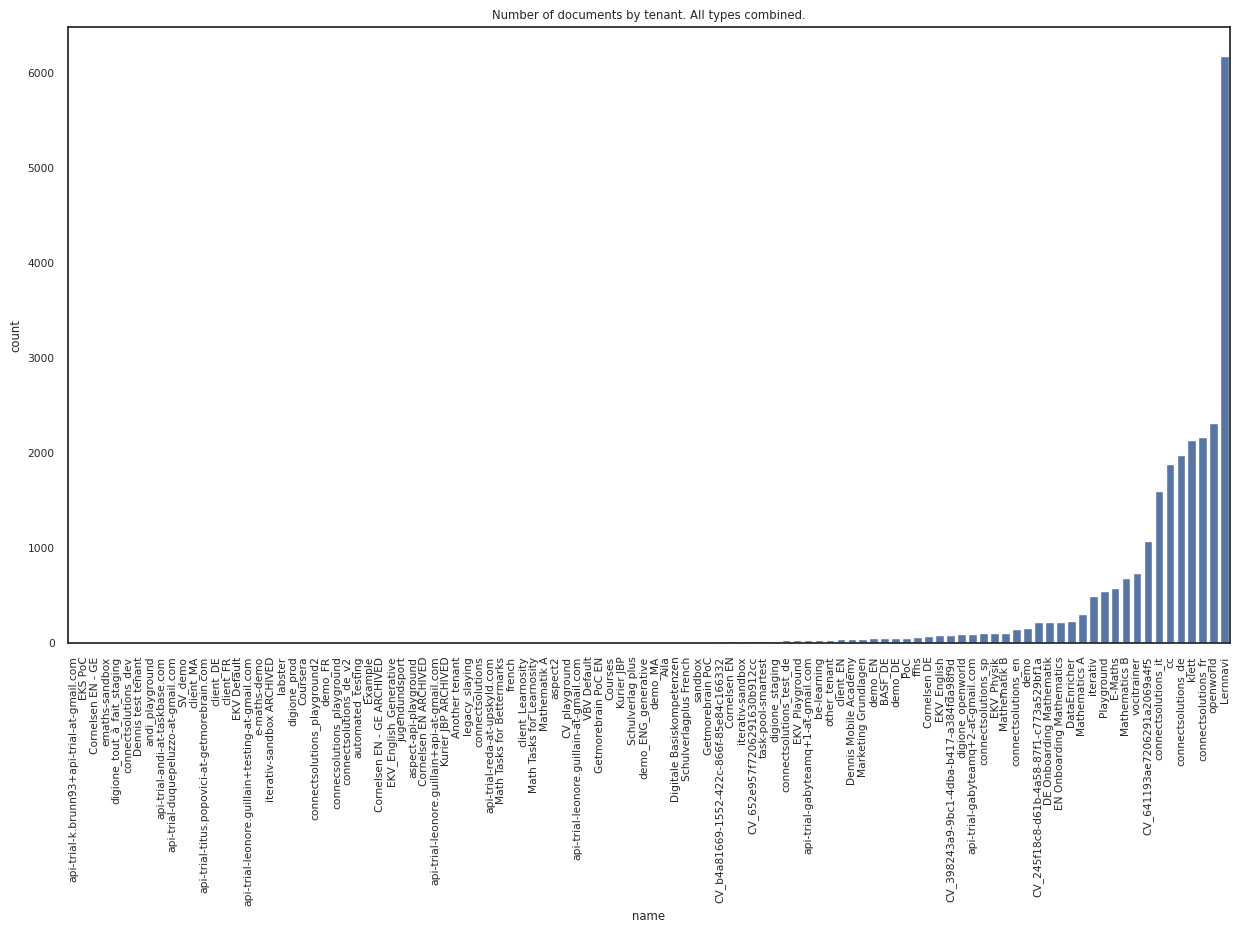

In [22]:
# Distribution of documents among tenants
tenants = df_content["tenant"].apply(pd.Series)
tenants_count = tenants.groupby(by="name").count()[["id"]].rename(columns={"id":"count"}).reset_index()

sns.set_theme(style='white', 
              font_scale=0.7, 
              rc={'figure.figsize':(15,8)})

ax = sns.barplot(data=tenants_count,
                 x="name",
                 y="count",
                 order=tenants_count.sort_values('count').name,
                 )
plt.xticks(rotation=90)
title = plt.title("Number of documents by tenant. All types combined.")

In [23]:
df_content = pd.concat([df_content, tenants], axis=1)

In [ ]:
# Distribution of documents' types among tenants 
sns.set_theme(style='white', 
              font_scale=0.7, 
              rc={'figure.figsize':(15,8)})

ax = sns.histplot(data=df_content,
                  x="name",
                  hue="type",
                  multiple="stack", 
                  palette=color_blind_colors,
                 )
ax.set_yscale("log")
plt.xticks(rotation=90)
title = plt.title("Number of documents by tenant. All types combined.")

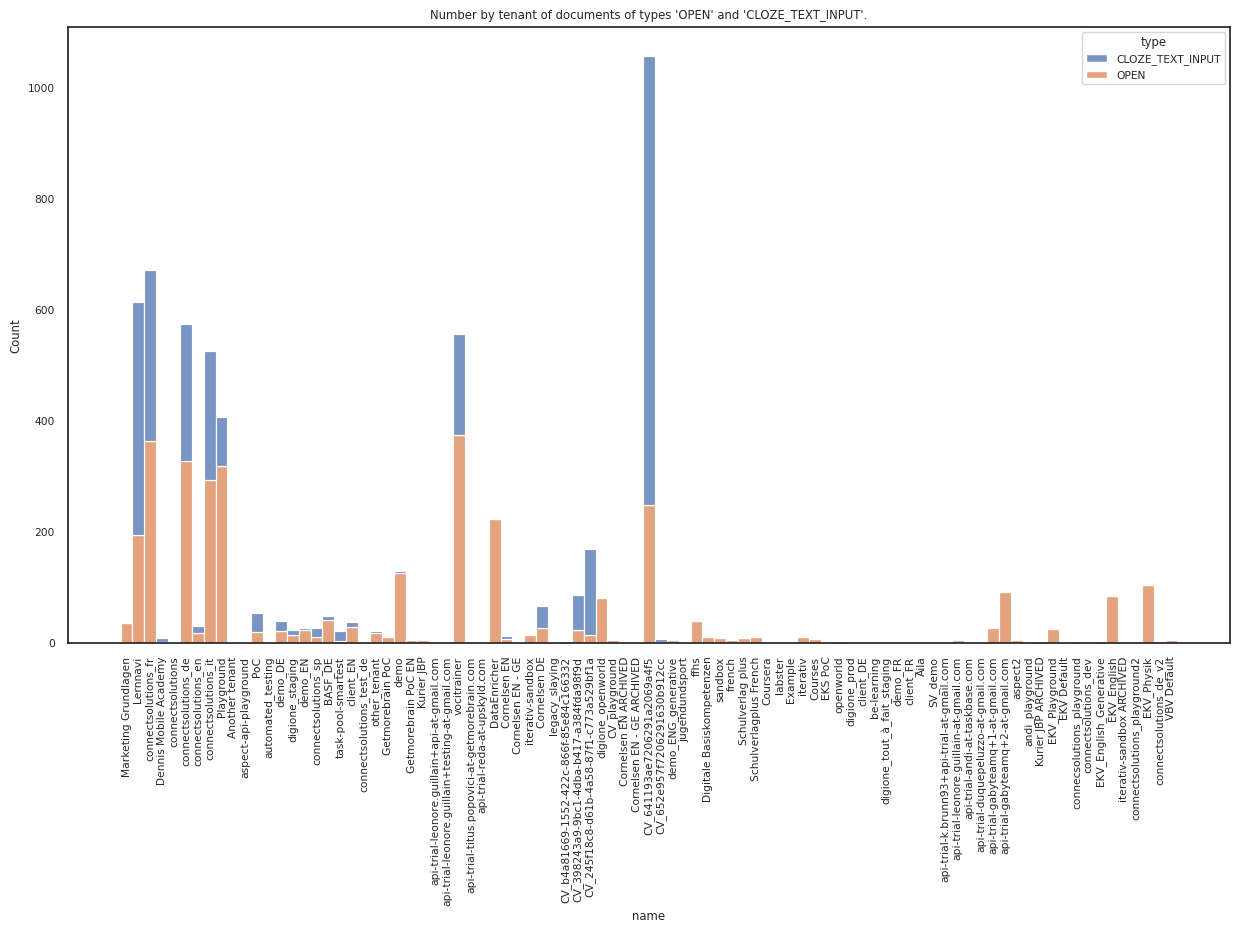

In [24]:
# Tenants with most CLOZE and OPEN tasks
task_types = ["OPEN", "CLOZE_TEXT_INPUT"]
df_cloze_open = df_content[df_content["type"].isin(task_types)]

ax = sns.histplot(data=df_cloze_open,
                  x="name",
                  hue="type",
                  multiple="stack"
                 )
# ax.set_yscale("log")
x = plt.xticks(rotation=90)
title = plt.title("Number by tenant of documents of types 'OPEN' and 'CLOZE_TEXT_INPUT'.")

**Cornelsen and EKV_Physik**

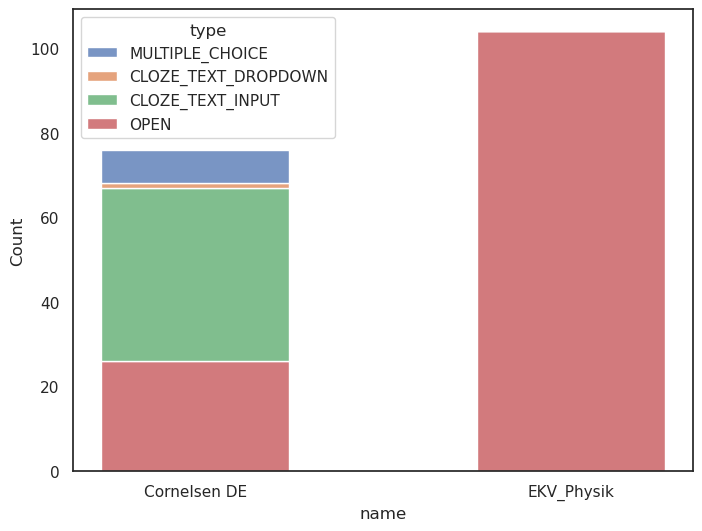

In [35]:
df_corn_ekv = df_content[df_content["name"].isin(["Cornelsen DE", "EKV_Physik"])]
sns.set_theme(style='white', 
              font_scale=1, 
              rc={'figure.figsize':(8,6)})

ax = sns.histplot(data=df_corn_ekv,
                  x="name",
                  hue="type",
                  multiple="stack",
                  shrink=0.5
                 )

In [56]:
# Lengths of descriptions => need pre-processing ? cleaning html tags 
clean_descriptions = df_cloze_open["description"].apply(lambda str: BeautifulSoup(str, 'html.parser').get_text().strip())
clean_descriptions = pd.DataFrame(clean_descriptions.reset_index(drop=True))
clean_descriptions["word_count"] = clean_descriptions["description"].apply(lambda s: len(s.split()))
clean_descriptions.sort_values(by="word_count", inplace=True)
L = len(clean_descriptions)

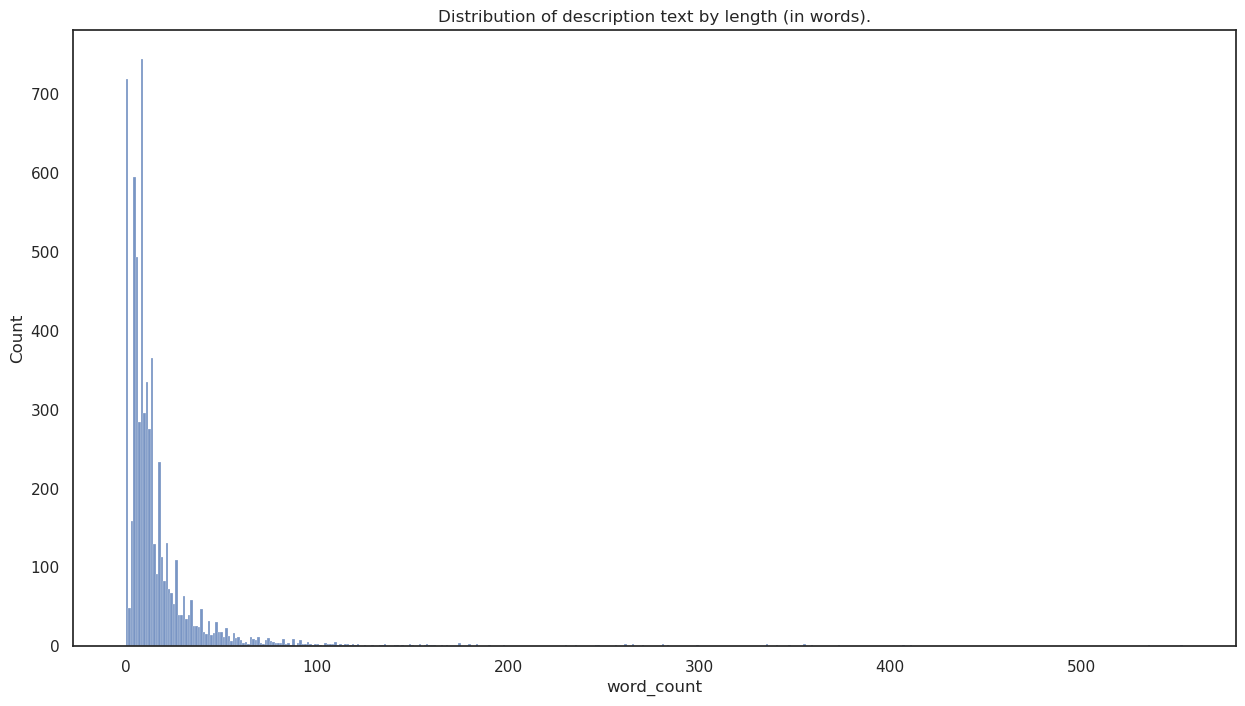

In [52]:
sns.set_theme(style='white', 
              rc={'figure.figsize':(15,8)})

sns.histplot(data=clean_descriptions,
                  x="word_count"
                 )
title = plt.title("Distribution of description text by length (in words).")

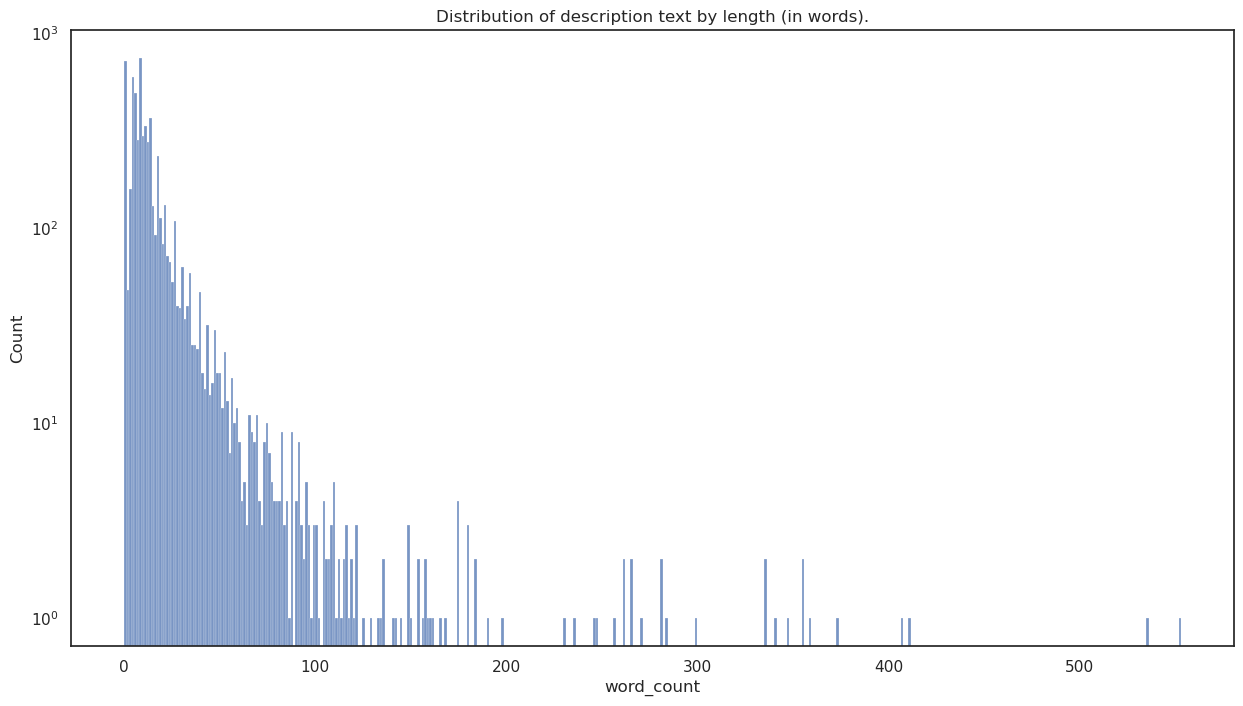

In [53]:
sns.set_theme(style='white', 
              rc={'figure.figsize':(15,8)})

ax = sns.histplot(data=clean_descriptions,
                  x="word_count"
                 )
ax.set_yscale("log")
title = plt.title("Distribution of description text by length (in words).")

In [60]:
# How many empty descriptions ?
empty = clean_descriptions[clean_descriptions["word_count"] == 0]
print("{:.2f}%".format(len(empty) / L * 100))

9.80%


In [62]:
# How heavy is the tail ?
tail = clean_descriptions[clean_descriptions["word_count"] > 200]
print("{:.2f}%".format(len(tail) / L * 100))

0.41%


In [64]:
# How heavy is the tail ?
tail = clean_descriptions[clean_descriptions["word_count"] > 100]
print("{:.2f}%".format(len(tail) / L * 100))

1.51%


In [ ]:
query = "SELECT * FROM Competences"
df_aspects = pd.read_sql(query, cnx)
# df_aspects.head()

df_aspects_cornelsen = df_aspects[df_aspects["tenantId"]==95]
df_aspects_ekvphysik = df_aspects[df_aspects["tenantId"]==140]
# df_aspects_cornelsen.head()
df_aspects_ekvphysik.head()

In [ ]:
query = "SELECT * FROM AspectConfigurations"
df_detectors = pd.read_sql(query, cnx)
df_detectors.head()